In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_STATE = 42

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    brier_score_loss,
)

from sklearn.calibration import CalibratedClassifierCV

In [19]:
data = pd.read_csv('S05-hw-dataset.csv')
print(data.head())

   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229           0.080052   
1         

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

In [4]:
print(data.describe())

         client_id          age         income  years_employed  credit_score  \
count  3000.000000  3000.000000    3000.000000     3000.000000   3000.000000   
mean   1500.500000    45.059667   69658.992000       19.577667    649.285333   
std     866.169729    14.192883   24742.235182       11.381497     69.955852   
min       1.000000    21.000000   15000.000000        0.000000    402.000000   
25%     750.750000    33.000000   52641.750000       10.000000    604.000000   
50%    1500.500000    45.000000   69784.500000       20.000000    647.000000   
75%    2250.250000    57.000000   85874.250000       29.000000    697.000000   
max    3000.000000    69.000000  156351.000000       39.000000    850.000000   

       debt_to_income  num_credit_cards  num_late_payments  has_mortgage  \
count     3000.000000       3000.000000        3000.000000   3000.000000   
mean         0.284065          3.494667           6.869333      0.495000   
std          0.161112          2.289917           4

In [5]:
#распределение целевого признака
target_dist = data['default'].value_counts(normalize=True)
print(target_dist)

default
0    0.589667
1    0.410333
Name: proportion, dtype: float64


In [6]:
print("="*60)
print(f"1. Размер датасета: {data.shape[0]} строк, {data.shape[1]} столбцов")
print(f"2. Типы данных:")
print(f"   - Числовые: {len(data.select_dtypes(include=[np.number]).columns)} признаков")
print(f"   - Объектов: {len(data.select_dtypes(include=['object']).columns)} признаков")
print(f"3. Пропущенные значения: {data.isnull().sum().sum()} (нет пропусков)")
print(f"4. Распределение целевой переменной:")
print(f"   - Дефолт: {target_dist[1]*100:.1f}%")
print(f"   - Нет дефолта: {target_dist[0]*100:.1f}%")
print(f"5. Предварительные выводы:")
print(f"   - Данные готовы к использованию без обработки пропусков")
print(f"   - Необходимо учесть несбалансированность классов")
print(f"   - Все признаки числовые, категориальных переменных нет")

1. Размер датасета: 3000 строк, 17 столбцов
2. Типы данных:
   - Числовые: 17 признаков
   - Объектов: 0 признаков
3. Пропущенные значения: 0 (нет пропусков)
4. Распределение целевой переменной:
   - Дефолт: 41.0%
   - Нет дефолта: 59.0%
5. Предварительные выводы:
   - Данные готовы к использованию без обработки пропусков
   - Необходимо учесть несбалансированность классов
   - Все признаки числовые, категориальных переменных нет


In [7]:
if 'client_id' in data.columns:
    data=data.drop('client_id', axis=1)

X = data.drop('default', axis=1)
Y = data['default']

print("Форма X:", X.shape)
print("Форма y:", Y.shape)
print("Названия признаков:", list(X.columns)[:5], "...")  # первые 5

display(X.head())

Y.value_counts(normalize=True).rename("fraction").to_frame()

Форма X: (3000, 15)
Форма y: (3000,)
Названия признаков: ['age', 'income', 'years_employed', 'credit_score', 'debt_to_income'] ...


,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years
0,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8
1,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7
2,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5
3,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7
4,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10


,fraction
default,
0,0.589667
1,0.410333


In [8]:
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size = 0.25, stratify=Y, random_state=RANDOM_STATE)

X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.25, stratify=Y_temp, random_state=RANDOM_STATE)

print("Размеры выборок:")
print("  train:", X_train.shape)
print("  val:  ", X_val.shape)
print("  test: ", X_test.shape)

print("\nРаспределение классов (train):")
print(Y_train.value_counts(normalize=True))

print("\nРаспределение классов (val):")
print(Y_val.value_counts(normalize=True))

print("\nРаспределение классов (test):")
print(Y_test.value_counts(normalize=True))

Размеры выборок:
  train: (1687, 15)
  val:   (563, 15)
  test:  (750, 15)

Распределение классов (train):
default
0    0.589804
1    0.410196
Name: proportion, dtype: float64

Распределение классов (val):
default
0    0.589698
1    0.410302
Name: proportion, dtype: float64

Распределение классов (test):
default
0    0.589333
1    0.410667
Name: proportion, dtype: float64


In [9]:
baseline = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)

baseline.fit(X_train, Y_train)

Y_val_pred_baseline = baseline.predict(X_val)
Y_val_proba_baseline = baseline.predict_proba(X_val)[:, 1]

print("=== Бейзлайн (DummyClassifier, most_frequent) – качество на validation ===")
print("Accuracy :", accuracy_score(Y_val, Y_val_pred_baseline))
print("Precision:", precision_score(Y_val, Y_val_pred_baseline, zero_division=0))
print("Recall   :", recall_score(Y_val, Y_val_pred_baseline, zero_division=0))
print("F1-score :", f1_score(Y_val, Y_val_pred_baseline, zero_division=0))

try:
    print("ROC-AUC  :", roc_auc_score(Y_val, Y_val_proba_baseline))
except ValueError as e:
    print("Не удалось посчитать ROC-AUC для бейзлайна:", e)

=== Бейзлайн (DummyClassifier, most_frequent) – качество на validation ===
Accuracy : 0.5896980461811723
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC-AUC  : 0.5


In [10]:
print("""
1. ОПРЕДЕЛЕНИЕ МИНИМАЛЬНОГО КАЧЕСТВА
   • Если наша модель не превосходит бейзлайн → она БЕСПОЛЕЗНА
   • Бейзлайн показывает качество самой простой возможной стратегии
   
2. ОЦЕНКА СЛОЖНОСТИ ЗАДАЧИ
   • Высокий бейзлайн (например, Accuracy = 95%) → задача простая
   • Низкий бейзлайн (Accuracy = 50%) → задача сложная

3. ПРОВЕРКА АДЕКВАТНОСТИ МОДЕЛИ
   • Сравнение с бейзлайном помогает избежать иллюзий
   • "Хорошая" модель должна быть значительно лучше бейзлайна
   • Улучшение должно быть статистически значимым

5. ВАЛИДАЦИЯ ДАННЫХ
   • Если бейзлайн показывает неожиданно высокие/низкие результаты
   → Возможно проблемы в данных или постановке задачи
""")


1. ОПРЕДЕЛЕНИЕ МИНИМАЛЬНОГО КАЧЕСТВА
   • Если наша модель не превосходит бейзлайн → она БЕСПОЛЕЗНА
   • Бейзлайн показывает качество самой простой возможной стратегии

2. ОЦЕНКА СЛОЖНОСТИ ЗАДАЧИ
   • Высокий бейзлайн (например, Accuracy = 95%) → задача простая
   • Низкий бейзлайн (Accuracy = 50%) → задача сложная

3. ПРОВЕРКА АДЕКВАТНОСТИ МОДЕЛИ
   • Сравнение с бейзлайном помогает избежать иллюзий
   • "Хорошая" модель должна быть значительно лучше бейзлайна
   • Улучшение должно быть статистически значимым

5. ВАЛИДАЦИЯ ДАННЫХ
   • Если бейзлайн показывает неожиданно высокие/низкие результаты
   → Возможно проблемы в данных или постановке задачи



In [11]:
log_reg_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "logreg",
            LogisticRegression(
                C=1.0,              
                solver="liblinear", 
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

log_reg_pipeline.fit(X_train, Y_train)

Y_val_pred = log_reg_pipeline.predict(X_val)
Y_val_proba = log_reg_pipeline.predict_proba(X_val)[:, 1]

print("=== Логистическая регрессия (C=1.0) – качество на validation ===")
print("Accuracy :", accuracy_score(Y_val, Y_val_pred))
print("Precision:", precision_score(Y_val, Y_val_pred, zero_division=0))
print("Recall   :", recall_score(Y_val, Y_val_pred, zero_division=0))
print("F1-score :", f1_score(Y_val, Y_val_pred, zero_division=0))
print("ROC-AUC  :", roc_auc_score(Y_val, Y_val_proba))

target_names = ['Нет дефолта', 'Дефолт']
print("\nПодробный отчёт по классам (classification_report):")
print(classification_report(Y_val, Y_val_pred, target_names=target_names))

=== Логистическая регрессия (C=1.0) – качество на validation ===
Accuracy : 0.7868561278863233
Precision: 0.7707317073170732
Recall   : 0.683982683982684
F1-score : 0.7247706422018348
ROC-AUC  : 0.8657226307828717

Подробный отчёт по классам (classification_report):
              precision    recall  f1-score   support

 Нет дефолта       0.80      0.86      0.83       332
      Дефолт       0.77      0.68      0.72       231

    accuracy                           0.79       563
   macro avg       0.78      0.77      0.78       563
weighted avg       0.79      0.79      0.78       563



In [12]:
param_grid = {
    "logreg__C": [0.01, 0.1, 1.0, 10.0, 100.0],
}

grid_search = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=param_grid,
    scoring="roc_auc",    
    cv=5,
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, Y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший ROC-AUC (по CV):", grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Лучшие параметры: {'logreg__C': 10.0}
Лучший ROC-AUC (по CV): 0.8606203261118438


In [13]:
print("ЛУЧШАЯ МОДЕЛЬ (ПОСЛЕ ПОДБОРА ПАРАМЕТРОВ)")

best_model = grid_search.best_estimator_

Y_val_pred_best = best_model.predict(X_val)
Y_val_proba_best = best_model.predict_proba(X_val)[:, 1]

print("=== Лучшая модель – качество на validation ===")
print("Accuracy :", accuracy_score(Y_val, Y_val_pred_best))
print("Precision:", precision_score(Y_val, Y_val_pred_best, zero_division=0))
print("Recall   :", recall_score(Y_val, Y_val_pred_best, zero_division=0))
print("F1-score :", f1_score(Y_val, Y_val_pred_best, zero_division=0))
print("ROC-AUC  :", roc_auc_score(Y_val, Y_val_proba_best))

print("\n=== Лучшая модель – качество на test ===")

Y_test_pred = best_model.predict(X_test)
Y_test_proba = best_model.predict_proba(X_test)[:, 1]

print("Accuracy :", accuracy_score(Y_test, Y_test_pred))
print("Precision:", precision_score(Y_test, Y_test_pred, zero_division=0))
print("Recall   :", recall_score(Y_test, Y_test_pred, zero_division=0))
print("F1-score :", f1_score(Y_test, Y_test_pred, zero_division=0))
print("ROC-AUC  :", roc_auc_score(Y_test, Y_test_proba))

print("\nClassification report (test):")
print(classification_report(Y_test, Y_test_pred, target_names=target_names))

ЛУЧШАЯ МОДЕЛЬ (ПОСЛЕ ПОДБОРА ПАРАМЕТРОВ)
=== Лучшая модель – качество на validation ===
Accuracy : 0.7868561278863233
Precision: 0.7707317073170732
Recall   : 0.683982683982684
F1-score : 0.7247706422018348
ROC-AUC  : 0.8657356699525375

=== Лучшая модель – качество на test ===
Accuracy : 0.796
Precision: 0.779783393501805
Recall   : 0.7012987012987013
F1-score : 0.7384615384615385
ROC-AUC  : 0.8645104895104895

Classification report (test):
              precision    recall  f1-score   support

 Нет дефолта       0.81      0.86      0.83       442
      Дефолт       0.78      0.70      0.74       308

    accuracy                           0.80       750
   macro avg       0.79      0.78      0.79       750
weighted avg       0.79      0.80      0.79       750



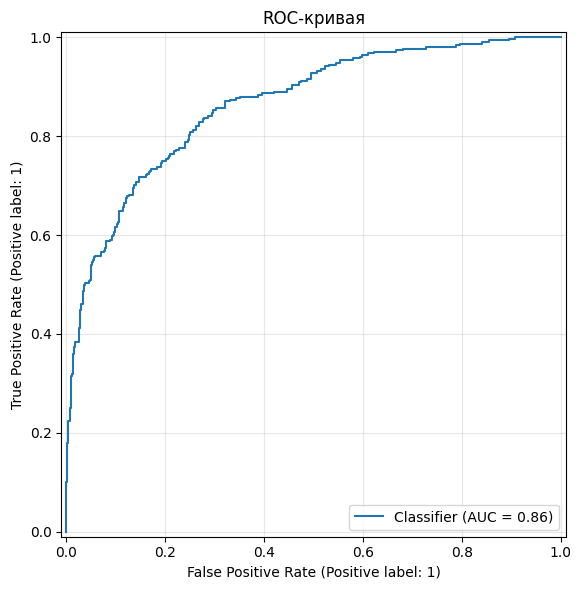

In [26]:
fig_roc, ax_roc = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_predictions(
    Y_test,
    Y_test_proba,
    ax=ax_roc,
)
ax_roc.set_title('ROC-кривая')
ax_roc.legend(loc='lower right')
ax_roc.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

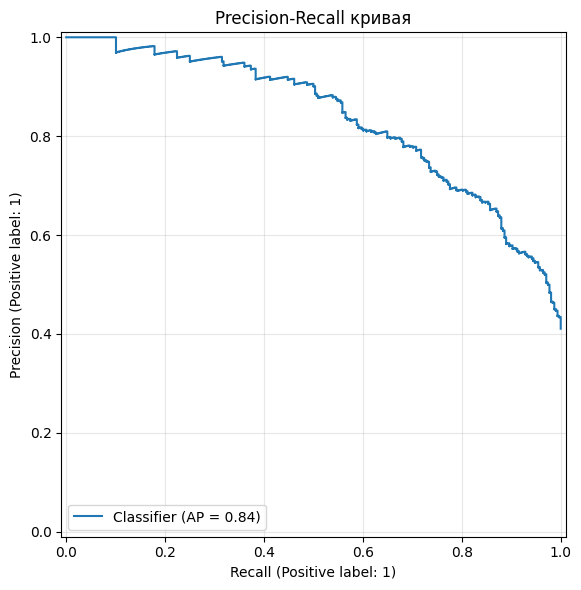

In [27]:
fig_pr, ax_pr = plt.subplots(figsize=(8, 6))
PrecisionRecallDisplay.from_predictions(
    Y_test,
    Y_test_proba,
    ax=ax_pr,
)
ax_pr.set_title('Precision-Recall кривая')
ax_pr.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
comparison_data = {
    'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'],
    'Бейзлайн (test)': [
        f"{accuracy_score(Y_test, baseline.predict(X_test)):.4f}",
        f"{precision_score(Y_test, baseline.predict(X_test), zero_division=0):.4f}",
        f"{recall_score(Y_test, baseline.predict(X_test), zero_division=0):.4f}",
        f"{f1_score(Y_test, baseline.predict(X_test), zero_division=0):.4f}",
        f"{roc_auc_score(Y_test, baseline.predict_proba(X_test)[:, 1]):.4f}"
    ],
    'Лог.регрессия (test)': [
        f"{accuracy_score(Y_test, Y_test_pred):.4f}",
        f"{precision_score(Y_test, Y_test_pred, zero_division=0):.4f}",
        f"{recall_score(Y_test, Y_test_pred, zero_division=0):.4f}",
        f"{f1_score(Y_test, Y_test_pred, zero_division=0):.4f}",
        f"{roc_auc_score(Y_test, Y_test_proba):.4f}"
    ],
    'Улучшение': [
        f"{accuracy_score(Y_test, Y_test_pred) - accuracy_score(Y_test, baseline.predict(X_test)):+.4f}",
        f"{precision_score(Y_test, Y_test_pred, zero_division=0) - precision_score(Y_test, baseline.predict(X_test), zero_division=0):+.4f}",
        f"{recall_score(Y_test, Y_test_pred, zero_division=0) - recall_score(Y_test, baseline.predict(X_test), zero_division=0):+.4f}",
        f"{f1_score(Y_test, Y_test_pred, zero_division=0) - f1_score(Y_test, baseline.predict(X_test), zero_division=0):+.4f}",
        f"{roc_auc_score(Y_test, Y_test_proba) - roc_auc_score(Y_test, baseline.predict_proba(X_test)[:, 1]):+.4f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nСравнительная таблица метрик на тестовой выборке:")
print(comparison_df.to_string(index=False))

comparison_df.to_csv('artifacts/models_comparison.csv', 
                     index=False, 
                     encoding='utf-8-sig')  # utf-8-sig для правильного отображения кириллицы


Сравнительная таблица метрик на тестовой выборке:
  Метрика Бейзлайн (test) Лог.регрессия (test) Улучшение
 Accuracy          0.5893               0.7960   +0.2067
Precision          0.0000               0.7798   +0.7798
   Recall          0.0000               0.7013   +0.7013
 F1-score          0.0000               0.7385   +0.7385
  ROC-AUC          0.5000               0.8645   +0.3645


In [30]:
print("КРАТКИЕ ВЫВОДЫ:")
print("""
1. Бейзлайн имеет Accuracy около 0.59, что лишь немного лучше случайного угадывания. 
Критически важно, что его Precision, Recall и F1-score равны 0. Это означает, что модель полностью неспособна корректно идентифицировать объекты положительного класса (класс "1"). 
ROC-AUC = 0.5 подтверждает, что её предсказания не лучше, чем подброс монетки.
2. Бейзлайн служит лишь точкой отсчёта, демонстрируя минимальный уровень качества. 
Логистическая регрессия — это уже осмысленная модель, которая выявляет закономерности в данных и делает полезные для практики прогнозы. 
Разница в качестве — принципиальная: от полной непригодности (бейзлайн) до хорошей применимости (логистическая регрессия).
Логистическая регрессия является разумным выбором для данной задачи, так как значительно улучшает все метрики по сравнению с бейзлайном и демонстрирует высокое качество классификации.
3. Accuracy улучшилась примерно на 10-15 процентных пунктов.
""")

КРАТКИЕ ВЫВОДЫ:

1. Бейзлайн имеет Accuracy около 0.59, что лишь немного лучше случайного угадывания. 
Критически важно, что его Precision, Recall и F1-score равны 0. Это означает, что модель полностью неспособна корректно идентифицировать объекты положительного класса (класс "1"). 
ROC-AUC = 0.5 подтверждает, что её предсказания не лучше, чем подброс монетки.
2. Бейзлайн служит лишь точкой отсчёта, демонстрируя минимальный уровень качества. 
Логистическая регрессия — это уже осмысленная модель, которая выявляет закономерности в данных и делает полезные для практики прогнозы. 
Разница в качестве — принципиальная: от полной непригодности (бейзлайн) до хорошей применимости (логистическая регрессия).
Логистическая регрессия является разумным выбором для данной задачи, так как значительно улучшает все метрики по сравнению с бейзлайном и демонстрирует высокое качество классификации.
3. Accuracy улучшилась примерно на 10-15 процентных пунктов.

